In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy

In [2]:
# Configure Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


__1.__ Download and create the MNIST train and validation datasets using torchvision:

In [3]:
# Define tranform - Convert data to tensor and normalize using dataset mean and std
# mean and std are computed offline using the training dataset
# tranforms.Normalize expects a value of mean and std per image channel
mnist_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

# download the dataset
mnist_train_dataset = datasets.MNIST('data', download = True, train = True, transform = mnist_transform)
mnist_val_dataset = datasets.MNIST('data', download = True, train = False, transform = mnist_transform)

# create data loaders and save them in a dict
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
mnist_val_dataloader = DataLoader(mnist_val_dataset, batch_size=64, shuffle=True)
dataloaders = dict(train=mnist_train_dataloader, val=mnist_val_dataloader)

In [33]:
# MNIST Dataloaders to get data into numpy for Logistic Regression -> batch = size of the data
mnist_train_dataloader_numpy = DataLoader(mnist_train_dataset, batch_size=len(mnist_train_dataset))
mnist_val_dataloader_numpy = DataLoader(mnist_val_dataset, batch_size=len(mnist_val_dataset))

In [34]:
# train dataset
X_y_train = next(iter(mnist_train_dataloader_numpy))
# test dataset
X_y_val = next(iter(mnist_val_dataloader_numpy))
# train data
X_train = X_y_train[0].numpy()
# train target
y_train = X_y_train[1].numpy()
# validation data
X_val = X_y_val[0].numpy()
# validation target
y_val = X_y_val[1].numpy()

__2.__ Info about the data

In [36]:
X_train.shape
# 28 x 28 images

(60000, 1, 28, 28)

In [37]:
X_val.shape

(10000, 1, 28, 28)

In [10]:
# get batch to extract properties and plot example images
# example_imgs has 64 images
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_train_dataloader))

D_in = np.prod(example_imgs.shape[1:])
D_out = len(mnist_train_dataloader.dataset.targets.unique())

print("Datasets shapes:", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})

print("N input features:", D_in, "Output classes:", D_out)

print("Train batch:", example_imgs.shape, example_targets.shape)
batch_idx, (example_imgs, example_targets) = next(enumerate(mnist_val_dataloader))
print("Val batch:", example_imgs.shape, example_targets.shape)

Datasets shapes: {'train': torch.Size([60000, 28, 28]), 'val': torch.Size([10000, 28, 28])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


__3.__ We can plot some examples with corresponding labels using the following function. This function can also receive the predicted labels.

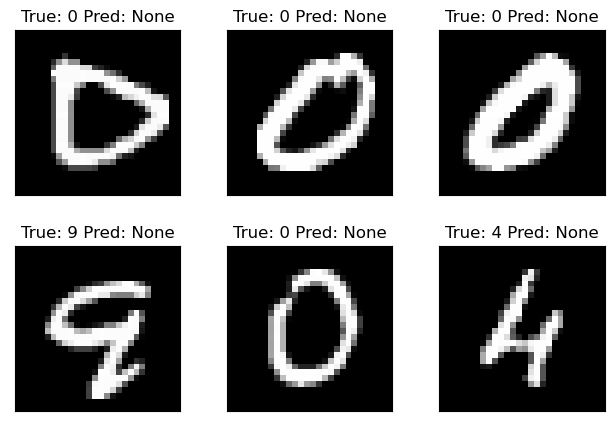

In [15]:
def plot_img_label_prediction(imgs, y_true, y_pred=None, shape=(2, 3)):
    y_pred = [None] * len(y_true) if y_pred is None else y_pred
    fig = plt.figure()
    for i in range(np.prod(shape)):
        plt.subplot(*shape, i+1)
        plt.tight_layout()
        
        plt.imshow(imgs[i][0], cmap='gray', interpolation='none')

        plt.title("True: {} Pred: {}".format(y_true[i], y_pred[i]))

        plt.xticks([])
        plt.yticks([])

plot_img_label_prediction(imgs=example_imgs, y_true=example_targets, y_pred=None, shape=(2, 3))

## Logistic Regression

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1))) # flatten the array, fit scaler and transform data
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1))) # flatten array and transform it to new scale

In [39]:
# sag -> stochastic average gradient descent
clf = LogisticRegression(C=50., multi_class='multinomial', solver = 'sag', tol = 0.1)
clf.fit(X_train, y_train)
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

Test score with penalty: 0.7249


We can select the coefficients for each class and reshape them into the image shape to plot them. This allows us to visualize what are the pixels that are contributing more to the classification for each of the digits. 

But what happens if the digits are not centered? Will we still get such a good performance? Lets test that out later!

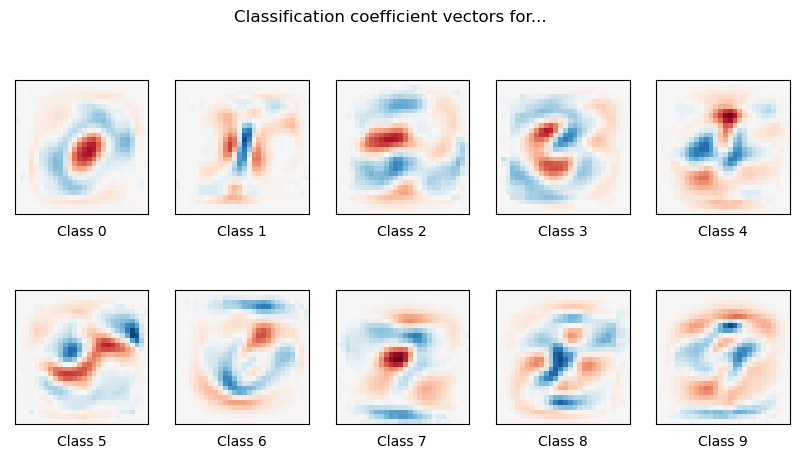

In [18]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

## Feed-Forward Neural Network

The first step is to create the functions that will allow us to implement a feed-forward neural network and manage the training and validation process.

The MLP class will define the architecture of a feed-forward neural network, with a set of hidden layers (fully connected layers [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)), with a activation function in between them ([relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu)), and a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) in the last layer. Since the dataset poses a multiclass classification problem, the last layer should have a number of neurons equal to the number of classes.

In [21]:
class MLP(nn.Module):
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        self.dim_layers = dim_layers # layers dimensions -> nr of neurons in each layer
        # initializes weights matrices of each layer
        layer_list = [nn.Linear(dim_layers[i], dim_layers[i+1]) for i in range(len(dim_layers) - 1)]
        self.lin_layers = nn.ModuleList(layer_list)
    
    def forward(self, X):
        X = X.view(-1, self.dim_layers[0])

        for layer in self.lin_layers[:-1]:
            # multiplies by the weights with layer(X)
            # applies ReLu
            X = F.relu(layer(X))
        
        return F.log_softmax(self.lin_layers[-1](X), dim = 1)

Training and validation function for MLP and CNN

In [22]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs = 25, scheduler = None, log_interval = None):
    begin_time = time.time()

    # save best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    losses, accs = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('---------------------------------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to train mode
            else:
                model.eval() # set model to validation mode

            running_loss = 0
            running_corrects = 0

            nsamples = 0

            # load the data -> return data + target for each batch
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # set optimizer parameters to zero
                optimizer.zero_grad()

                # enable gradient if in trainning
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # calls forward
                    a, preds = torch.max(outputs, 1) # gets predictions with max(probabilities returned by softmax)
                    loss = criterion(outputs, labels) # computes loss

                    # if in training, do backprop before new batch arives
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # save loss and correct predictions for this batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            # save loss and correct predictions for this epoch
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples
            losses[phase].append(epoch_loss)
            accs[phase].append(epoch_acc)

            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.2f}%'.format(phase, epoch_loss, 100 * epoch_acc))
            
            # deep copy the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - begin_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights to return
    model.load_state_dict(best_model_wts)

    return model, losses, accs

We will start by creating a simple network with some hidden layers. Thus, in addition to the input, it will have 3 fully connected layer which, in this implemetation, is assigned to the input of the MLP Class. We will use the Stochastic Gradient Descend optimizer ([optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)) with 0.01 learning rate and 0.5 momentum. The loss function to be optimized will be negative log likelihood ([nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). Training and validation will be managed by the function "train_val_model" previously define.

Epoch 0/14
---------------------------------------
train Loss: 0.7898 Acc: 77.33%
val Loss: 0.2961 Acc: 91.49%

Epoch 2/14
---------------------------------------
train Loss: 0.1805 Acc: 94.71%
val Loss: 0.1560 Acc: 95.42%

Epoch 4/14
---------------------------------------
train Loss: 0.1113 Acc: 96.67%
val Loss: 0.1073 Acc: 96.78%

Epoch 6/14
---------------------------------------
train Loss: 0.0764 Acc: 97.71%
val Loss: 0.0925 Acc: 97.11%

Epoch 8/14
---------------------------------------
train Loss: 0.0553 Acc: 98.39%
val Loss: 0.0852 Acc: 97.28%

Epoch 10/14
---------------------------------------
train Loss: 0.0402 Acc: 98.82%
val Loss: 0.0800 Acc: 97.47%

Epoch 12/14
---------------------------------------
train Loss: 0.0292 Acc: 99.16%
val Loss: 0.0747 Acc: 97.77%

Epoch 14/14
---------------------------------------
train Loss: 0.0213 Acc: 99.46%
val Loss: 0.0708 Acc: 97.75%

Training complete in 3m 26s
Best val Acc: 97.78%


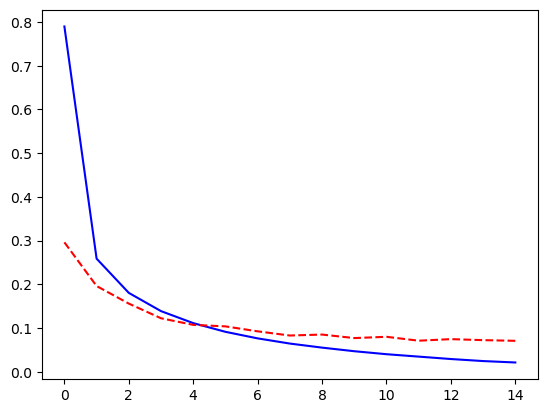

In [23]:
model_mlp = MLP([D_in, 256, 128, 64, D_out]).to(device) # [D_in, 512, 256, 128, 64, D_out]

optimizer = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model_mlp, losses, accuracies = train_val_model(model_mlp, criterion, optimizer, dataloaders,
                       num_epochs=15, log_interval=2)

plt.plot(losses['train'], '-b', losses['val'], '--r')

## Convolutional Neural Network

The initialization (`__init__`) function will define the architecture and the `foward` function will implement how the different layers are connected. This architecture will be a sequece of 2 convolutional layers ([nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) (1st: output channels 10, kernel size 5; 2nd: output channels 20, kernel size 5), then 2 fully connected layers ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) (1st: output features 50; 2nd: output features 10 (the number of classes)). Once again, the final layer will be a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax) function  that will choose the most probable class of the 10 in the input.

Between the second convolution layer and the first fully connected, we will set a dropout layer ([nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html)). The idea behind dropout is to disable a percentage of randomly selected neurons during each step of the training phase, in order to avoid overfitting.

In [24]:
class CNN(nn.Module):
    """Basic Pytorch CNN for MNIST-like data."""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, T=1.0):
        # Batch size = 64, images 28x28 => x.shape = [64, 1, 28, 28]

        # Convolution with 5x5 filter without padding and 10 channels => x.shape = [64, 10, 24, 24] since 24 = 28 - 5 + 1
        # Max pooling with stride of 2 => x.shape = [64, 10, 12, 12]
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # Convolution with 5x5 filter without padding and 20 channels => x.shape = [64, 20, 8, 8] since 8 = 12 - 5 + 1
        # Max pooling with stride of 2 => x.shape = [64, 20, 4, 4]
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # Reshape => x.shape = [64, 320] since 320 = 20 x 4 x 4
        x = x.view(-1, 320)

        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)

        x = self.fc2(x)

        x = F.log_softmax(x, dim=1)
        
        return x

Epoch 0/24
---------------------------------------
train Loss: 0.5131 Acc: 84.10%
val Loss: 0.0973 Acc: 96.86%

Epoch 2/24
---------------------------------------
train Loss: 0.2058 Acc: 94.04%
val Loss: 0.0573 Acc: 98.04%

Epoch 4/24
---------------------------------------
train Loss: 0.1669 Acc: 95.20%
val Loss: 0.0511 Acc: 98.34%

Epoch 6/24
---------------------------------------
train Loss: 0.1483 Acc: 95.63%
val Loss: 0.0390 Acc: 98.57%

Epoch 8/24
---------------------------------------
train Loss: 0.1334 Acc: 96.13%
val Loss: 0.0362 Acc: 98.73%

Epoch 10/24
---------------------------------------
train Loss: 0.1258 Acc: 96.27%
val Loss: 0.0340 Acc: 98.89%

Epoch 12/24
---------------------------------------
train Loss: 0.1224 Acc: 96.50%
val Loss: 0.0325 Acc: 98.89%

Epoch 14/24
---------------------------------------
train Loss: 0.1139 Acc: 96.58%
val Loss: 0.0342 Acc: 98.82%

Epoch 16/24
---------------------------------------
train Loss: 0.1111 Acc: 96.70%
val Loss: 0.0328 A

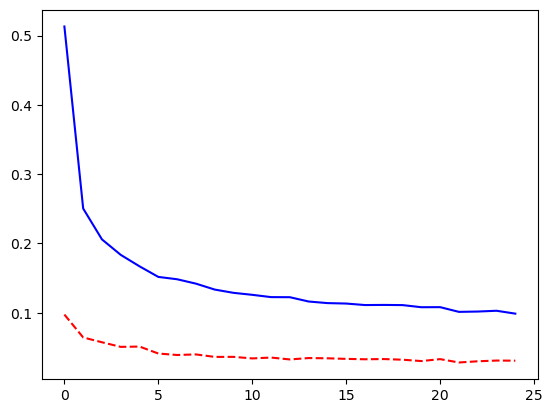

In [25]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=25, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

We have now completed training and validation with 3 different models: Logistic Regression, Feed-Forward Network, and Convolutional Neural Network. 

We have seen that with the CNN, the performance of the model in the validation set, outperforms the other models (~99% accuracy against ~90% and ~98%). 

The difference in performance between CNNs and MLP is small but how many learnable parameters are we using in the MLP and in CNN models?

We can find it out using the following lines of code:

In [27]:
model_parameters_mlp = filter(lambda p: p.requires_grad, model_mlp.parameters())
params_mlp = sum([np.prod(p.size()) for p in model_parameters_mlp])
print('Number of parameters in the MLP model: {}'.format(params_mlp))

model_parameters_cnn = filter(lambda p: p.requires_grad, model.parameters())
params_cnn = sum([np.prod(p.size()) for p in model_parameters_cnn])
print('Number of parameters in the CNN model: {}'.format(params_cnn))

Number of parameters in the MLP model: 242762
Number of parameters in the CNN model: 21840


You can see that we have ~11x more learnable parameters to achieve almost the same performance.

We can experiment training a feed forward network with the same nr of parameters as the CNN

In [28]:
model_mlp_test = MLP([D_in, 32, D_out]).to(device)
model_parameters_mlp_test = filter(lambda p: p.requires_grad, model_mlp_test.parameters())
params_mlp_test = sum([np.prod(p.size()) for p in model_parameters_mlp_test])
print('Number of parameters in the MLP model: {}'.format(params_mlp_test))

Number of parameters in the MLP model: 25450


Epoch 0/14
---------------------------------------
train Loss: 0.4732 Acc: 86.96%
val Loss: 0.2810 Acc: 92.07%

Epoch 5/14
---------------------------------------
train Loss: 0.1528 Acc: 95.69%
val Loss: 0.1459 Acc: 95.72%

Epoch 10/14
---------------------------------------
train Loss: 0.1087 Acc: 96.87%
val Loss: 0.1161 Acc: 96.55%

Training complete in 3m 17s
Best val Acc: 96.88%


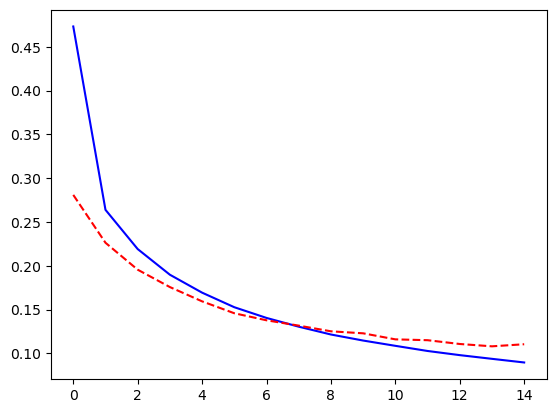

In [29]:
optimizer = optim.SGD(model_mlp_test.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model_mlp_test, losses, accuracies = train_val_model(model_mlp_test, criterion, 
                                                     optimizer, dataloaders,
                                                     num_epochs=15, 
                                                     log_interval=5)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

CNNs are expected to be invariant to the location where important features occur in the input. In fact, it's not unusual that there is a dataset shift where the data acquisition process suffers some modification. We will do this by applying a transformation with horizontal translations to our validation dataset and see how robust each model is to these shifts.

We can do this by going back to **0.1 - Create Dataloaders -
MNIST dataset** cell to define the test transform using the following code 

```
mnist_transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomAffine(0, translate=[0.1, 0]),
     transforms.Normalize((0.1307,), (0.3081,))])
```

and replace

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform)`

with

`mnist_val_dataset = datasets.MNIST('../data', download=True, train=False, transform=mnist_transform_test)`

After rerunning the different models we can see that the accuracy of the Logistic Regression drops from ~90% to ~72%, the MLP drops from ~98% to ~87%, and the CNN drops from ~99% to ~97%. This shows that the learned features are more robust to variances in location, as expected.

## Using the models in a new dataset

In this case we will use the Scikit-Learn's digits dataset

## Scikit-Learn Digits

This dataset is provided by scikit-learn and the digit images are returned as numpy ndarray. We will use PIL (Python Image Library) to convert the numpy ndarray to a image, tranform it to a tensor and normalize it.

In this case we don't have a predefined Digits Dataset provided by torchvision so we will need to write a custom Dataset class and implement three functions: 

`__init__`, `__len__`, and `__getitem__`.

Scikit-Learn return the digits images and labels as ndarrays. Each digit image is an 8x8 array.

To use the previous CNN, we will use a transform to resize the images to the MNIST image size.

In [41]:
SKLEARN_DIGITS_TRAIN_SIZE = 1247
SKLEARN_DIGITS_VAL_SIZE = 550

class NumpyDataset(Dataset):

  def __init__(self, data, targets, transform=None):
    self.data = torch.from_numpy(data).float()
    self.targets = torch.from_numpy(targets).long()
    self.transform = transform

  def __getitem__(self, index):
    x = np.expand_dims(self.data[index], axis=2)
    y = self.targets[index]
    if self.transform:
        x = self.transform(x)
    return x, y

  def __len__(self):
    return len(self.data) 

digits_transform = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.Resize(28),
                                       transforms.ToTensor(),
                                       ])

# Get sklearn digits dataset
X, y = load_digits(return_X_y=True)
X = X.reshape((len(X), 8, 8))
y_train = y[:-SKLEARN_DIGITS_VAL_SIZE]
y_val = y[-SKLEARN_DIGITS_VAL_SIZE:]
X_train = X[:-SKLEARN_DIGITS_VAL_SIZE]
X_val = X[-SKLEARN_DIGITS_VAL_SIZE:]

digits_train_dataset = NumpyDataset(X_train, y_train, transform=digits_transform)
digits_val_dataset = NumpyDataset(X_val, y_val, transform=digits_transform)
digits_train_dataloader = torch.utils.data.DataLoader(digits_train_dataset, batch_size=64, shuffle=True)
digits_val_dataloader = torch.utils.data.DataLoader(digits_val_dataset, batch_size=64, shuffle=True)

dataloaders = dict(train=digits_train_dataloader, val=digits_val_dataloader)

In [42]:
# Get some examples of images and targets
_, (example_train_imgs, example_train_targets) = next(enumerate(digits_train_dataloader))
_, (example_val_imgs, example_val_targets) = next(enumerate(digits_val_dataloader))

# Info about the dataset
D_in = np.prod(example_imgs.shape[1:])
D_out = len(digits_train_dataloader.dataset.targets.unique())

# Output information
print("Datasets shapes (before transformations):", {x: dataloaders[x].dataset.data.shape for x in ['train', 'val']})
print("N input features:", D_in, "Output classes:", D_out)
print("Train batch:", example_train_imgs.shape, example_train_targets.shape)
print("Val batch:", example_val_imgs.shape, example_val_targets.shape)

Datasets shapes (before transformations): {'train': torch.Size([1247, 8, 8]), 'val': torch.Size([550, 8, 8])}
N input features: 784 Output classes: 10
Train batch: torch.Size([64, 1, 28, 28]) torch.Size([64])
Val batch: torch.Size([64, 1, 28, 28]) torch.Size([64])


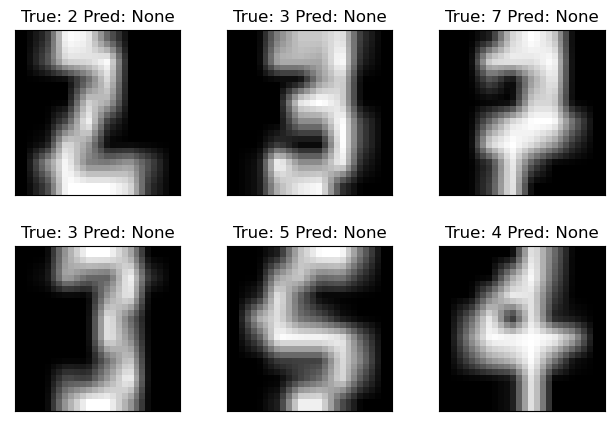

In [43]:
plot_img_label_prediction(imgs=example_train_imgs, y_true=example_train_targets, y_pred=None, shape=(2, 3))


### Logistic Regression

In [44]:
scaler = StandardScaler()
print(X_train.squeeze().shape)
X_train = scaler.fit_transform(np.reshape(X_train, (X_train.shape[0], -1)))
X_val = scaler.transform(np.reshape(X_val, (X_val.shape[0], -1)))

(1247, 8, 8)


In [45]:
clf.fit(X_train, y_train)
#sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_val, y_val)

print("Test score with penalty: %.4f" % score)

Test score with penalty: 0.8836


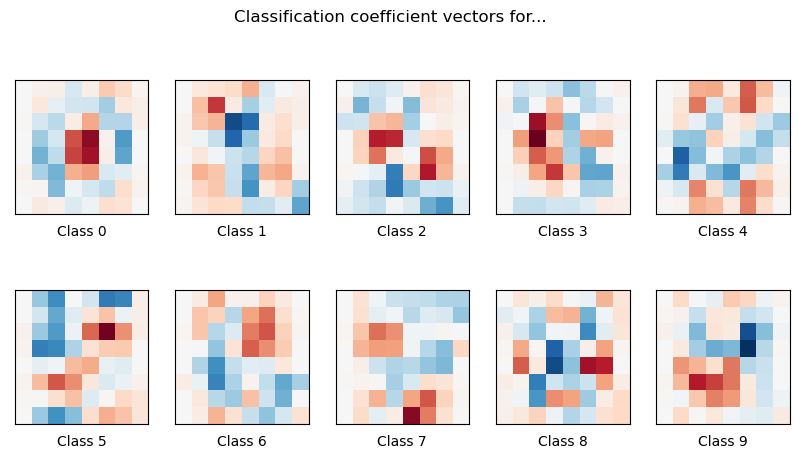

In [46]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(8, 8), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification coefficient vectors for...')

plt.show()

## Feed Forward Network

Epoch 0/19
---------------------------------------
train Loss: 2.2009 Acc: 29.51%
val Loss: 2.0436 Acc: 38.55%

Epoch 2/19
---------------------------------------
train Loss: 0.9261 Acc: 83.16%
val Loss: 0.7648 Acc: 79.82%

Epoch 4/19
---------------------------------------
train Loss: 0.3363 Acc: 89.90%
val Loss: 0.5839 Acc: 81.64%

Epoch 6/19
---------------------------------------
train Loss: 0.1652 Acc: 95.67%
val Loss: 0.3776 Acc: 88.36%

Epoch 8/19
---------------------------------------
train Loss: 0.1269 Acc: 95.91%
val Loss: 0.5030 Acc: 83.45%

Epoch 10/19
---------------------------------------
train Loss: 0.0940 Acc: 97.35%
val Loss: 0.4152 Acc: 88.18%

Epoch 12/19
---------------------------------------
train Loss: 0.0899 Acc: 97.19%
val Loss: 0.3469 Acc: 89.45%

Epoch 14/19
---------------------------------------
train Loss: 0.0639 Acc: 98.24%
val Loss: 0.3006 Acc: 91.45%

Epoch 16/19
---------------------------------------
train Loss: 0.0567 Acc: 98.40%
val Loss: 0.3676 A

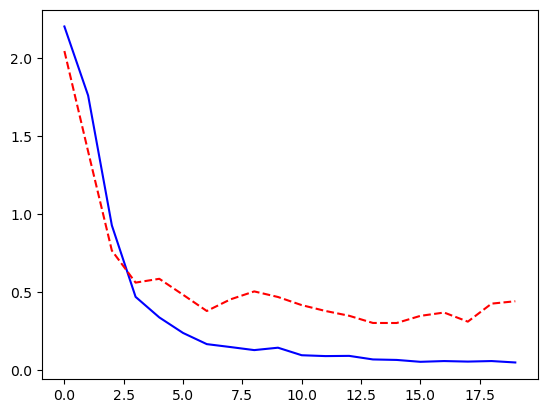

In [47]:
model = MLP([D_in, 512, 256, 128, 64, D_out]).to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=20, log_interval=2)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

### CNN

Epoch 0/49
---------------------------------------
train Loss: 2.1513 Acc: 22.45%
val Loss: 1.7371 Acc: 69.64%

Epoch 10/49
---------------------------------------
train Loss: 0.2997 Acc: 90.86%
val Loss: 0.2819 Acc: 92.18%

Epoch 20/49
---------------------------------------
train Loss: 0.1888 Acc: 94.07%
val Loss: 0.2315 Acc: 94.00%

Epoch 30/49
---------------------------------------
train Loss: 0.1262 Acc: 95.27%
val Loss: 0.2515 Acc: 94.00%

Epoch 40/49
---------------------------------------
train Loss: 0.1042 Acc: 96.55%
val Loss: 0.2301 Acc: 94.00%

Training complete in 0m 21s
Best val Acc: 95.09%


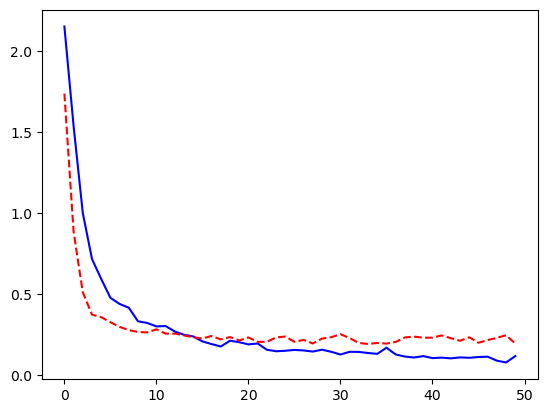

In [48]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders,
                       num_epochs=50, log_interval=10)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')